## Initial setup

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import time
import sklearn.metrics as metrics
import multiprocessing
from multiprocessing import Pool
from multiprocessing import Queue
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('..')
from src import logistic_regression as lr
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

# set matplotlib config
%matplotlib notebook

# set default figure size
matplotlib.rcParams["figure.dpi"] = 100

# read data
df_competition_evaluation = pd.read_csv("~/Projects/github/glm-competition/data/df_competition.csv")

# format data
data = df_competition_evaluation.values  # convert data frame to numpy array
m, n = data[:, :-1].shape
X = np.concatenate((np.ones((m, 1)), data[:, :-1]), axis=1)
y = data[:, -1]

## Visualise data

<IPython.core.display.Javascript object>


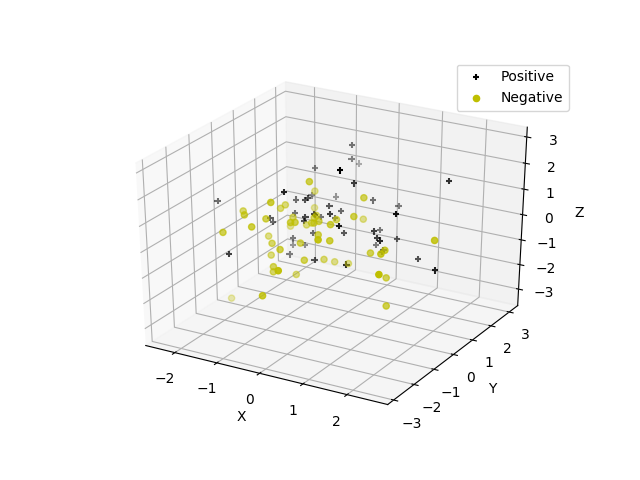

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[data[:, -1] == 1, 0], data[data[:, -1] == 1, 1],
           data[data[:, -1] == 1, 2], color='k', marker='+', label="Positive")
ax.scatter(data[data[:, -1] == 0, 0], data[data[:, -1] == 0, 1],
           data[data[:, -1] == 0, 2], color='y', marker='o', label="Negative")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend(loc="upper right", frameon=True, fancybox=True)
plt.show()

## Benchmark performance

In [3]:
def calculateAUC(model="bgd", seed=41):
    random.seed(seed)
    n = len(df_competition_evaluation)

    # divide into training and test
    l = range(0, n)
    k = int(0.6 * (n))
    training_index = random.sample(l, k)
    df_training = df_competition_evaluation.iloc[training_index]
    test_index = [x for x in l if x not in training_index]
    df_test = df_competition_evaluation.iloc[test_index]
    
    # convert train data
    data_tr = df_training.values
    m, n = data_tr[:, :-1].shape
    X_train_scikit = data_tr[:, :-1]
    X_train = np.concatenate((np.ones((m, 1)), data_tr[:, :-1]), axis=1)
    y_train = data_tr[:, -1]
    
    # convert test data
    data_t = df_test.values
    m, n = data_t[:, :-1].shape
    X_test_scikit = data_t[:, :-1]
    X_test = np.concatenate((np.ones((m, 1)), data_t[:, :-1]), axis=1)
    y_test = data_t[:, -1]

    # initialize theta to zeros
    initial_theta = np.zeros(df_test.shape[1])

    # calculate theta
    if model == "bgd":
        glm_results = lr.my_logistic_regression(df_training)
    elif model == "sci":
        res = minimize(lr.costFunction, initial_theta, args=(X_train, y_train),
                       method=None, jac=lr.calculateGradient, options={"maxiter": 5000})
        glm_results = res.x
    elif model == "sgd":
        clf = SGDClassifier(loss="log", alpha=0.1, max_iter=5000, tol=0.00001)
        clf.fit(X_train_scikit, y_train)
        predictions = clf.predict(X_test_scikit)
        return (metrics.roc_auc_score(y_test, predictions))
    elif model == "lgr":
        lgr = LogisticRegression(penalty="l2", C=0.1, tol=0.00001)
        lgr.fit(X_train_scikit, y_train)
        predictions = lgr.predict(X_test_scikit)
        return (metrics.roc_auc_score(y_test, predictions))

    # calculate the raw predictions on the test set
    a0 = glm_results[0]
    a1 = glm_results[1]
    a2 = glm_results[2]
    a3 = glm_results[3]

    glm_pred = 1 / \
        (1 + np.exp(-(a0 + a1 * df_test['V1'] +
                      a2 * df_test['V2'] + a3 * df_test['V3'])))

    # calculate the ROC
    TPR = []
    FPR = []
    thresholds = np.arange(0, 1.001, 0.001)
    m = len(thresholds)
    pd.options.mode.chained_assignment = None  # default='warn'
    df_test['glm_pred'] = glm_pred

    for threshold in thresholds:
        TP = len(df_test[(df_test['Target'] == 1) &
                         (df_test['glm_pred'] > threshold)])
        FN = len(df_test[(df_test['Target'] == 1) &
                         (df_test['glm_pred'] < threshold)])
        FP = len(df_test[(df_test['Target'] == 0) &
                         (df_test['glm_pred'] > threshold)])
        TN = len(df_test[(df_test['Target'] == 0) &
                         (df_test['glm_pred'] < threshold)])
        TPR.append(TP / (TP + FN))
        FPR.append(FP / (FP + TN))

    TPR[0] = 1
    FPR[0] = 1
    TPR[m - 1] = 0
    FPR[m - 1] = 0

    # Integrating the ROC to get the AUC
    c = np.array([sum(n) / 2 for n in zip(*[TPR[0:(m - 1)], TPR[1:m]])])
    AUC = abs(round(sum(np.diff(FPR) * c), 3))

    return AUC

## Compare results

In [ ]:
if __name__ == '__main__':
    AUC_sci = 0
    AUC_sgd = 0
    AUC_lgr = 0
    AUC_bgd = 0
    iters = 0
    
    # set up workers
    pool1 = Pool()
    
    start_time = time.time()
    for seed in range(0, 1000):
        AUC_sci += pool1.apply_async(calculateAUC, args=("sci", seed)).get()
        AUC_sgd += pool1.apply_async(calculateAUC, args=("sgd", seed)).get()
        AUC_lgr += pool1.apply_async(calculateAUC, args=("lgr", seed)).get()
        AUC_bgd += pool1.apply_async(calculateAUC, args=("bgd", seed)).get()
        iters += 1
    
    pool1.close()
        
    print("AUC using SciPy optimize:\n", AUC_sci / iters)
    print("AUC using scikit-learn SGDClassifier:\n", AUC_sgd / iters)
    print("AUC using scikit-learn LogisticRegression:\n", AUC_lgr / iters)
    print("AUC using BGD:\n", AUC_bgd / iters)
    print("\n")
    print("Run time using parallel processing:")
    print("--- %s seconds ---" % (time.time() - start_time))